# Canola Oil Predictor

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Import Data

In [2]:
#reads in intended result csv, to fill in later, and finds regions we are trying to predict
result = pd.read_csv("to_be_filled.csv")
regions = result['Region'].unique()

In [3]:
#import data of target variables
deliveries = pd.read_csv("data/1. Target Variables/Canada_Canola_Producer_Deliveries.csv")
prices = pd.read_csv("data/1. Target Variables/Canada_Canola_Producer_Prices.csv")

In [4]:
#import relevant weather data
elNino = pd.read_csv("data/4. Spatio-Temporal & Weather Data/El_Niño_Southern_Oscillation_Index.csv")

Data given for rain, temp, soil moisture is split into separate CSV files for each year, so here we concatenate them.

In [5]:
#method for looping through to import and concatenate csvs
def concatenate_csvs(path, years, start=2000):
    """
    Input: Path containing many csvs with the same columns
    Output: Single dataframe with all csvs concatenated
    
    path - str, path of csvs, with {} substituted for years
    years - int, years the function should loop for
    start - int, year the function should start from
    """
    dfs = []
    for i in range(years):
        year = start + i
        filepath = path.format(year)
        dfs.append(pd.read_csv(filepath))
    return pd.concat(dfs)

In [6]:
#concatenate rainfall CSVs
rain_path = "data/4. Spatio-Temporal & Weather Data/Rainfall/canada_rainfall_{}.csv"
rain_years = 21
rain = concatenate_csvs(rain_path, rain_years)

In [7]:
#concatenate soil moisture CSVs
sm_path = "data/4. Spatio-Temporal & Weather Data/Soil Moisture/canada_soil_moisture{}.csv"
sm_years = 11
sm_start = 2010
sm = concatenate_csvs(sm_path, sm_years, start = sm_start)

In [8]:
#concatenate temperature moisture CSVs
temp_path = "data/4. Spatio-Temporal & Weather Data/Temperature/canada_temp_{}.csv"
temp_years = 21
temp = concatenate_csvs(temp_path, temp_years)

## Transform Data Into Workable Format

In [9]:
#format dates as YYYY-MM-DD
if 'start' not in rain.keys():
    rain.insert(2, 'start', pd.to_datetime(rain['start_date']))
    rain.insert(3, 'end', pd.to_datetime(rain['end_date']))
if 'start' not in sm.keys():
    sm.insert(2, 'start', pd.to_datetime(sm['start_date']))
    sm.insert(3, 'end', pd.to_datetime(sm['end_date']))
if 'start' not in temp.keys():
    temp.insert(2, 'start', pd.to_datetime(temp['start_date']))
    temp.insert(3, 'end', pd.to_datetime(temp['end_date']))
if 'start' not in elNino.keys():
    elNino.insert(2, 'start', pd.to_datetime(elNino['Start Date']))
    elNino.insert(3, 'end', pd.to_datetime(elNino['End Date']))

In [10]:
#format to keep only relevant columns
rain_f = rain[['start','end', 'value', 'region_id', 'region_name', 'province_name', 'year']]
sm_f = sm[['start','end', 'value', 'region_id', 'region_name', 'province_name', 'year']]
temp_f = temp[['start','end', 'value', 'region_id', 'region_name', 'province_name', 'year']]
elNino_f = elNino[['start','end', 'Value']].rename(str.lower, axis='columns').set_index('end')

In [11]:
#format to keep only relevant columns
deliveries_f = deliveries[['Region', 'Start Date', 'End Date', 'Value']].rename(str.lower, axis='columns')
prices_f = prices[['Region', 'Start Date', 'End Date', 'Value']].rename(str.lower, axis='columns')

Splits each dataframe into lists of dataframes. Index in lists correspond to list of regions identified earlier.

In [12]:
prices_by_region = []
deliveries_by_region = []
rain_by_region = []
sm_by_region = []
temp_by_region = []
for region in regions:
    prices_by_region.append(prices_f[prices_f.region == region].set_index('end date'))
    deliveries_by_region.append(deliveries_f[deliveries_f.region == region].set_index('end date'))
    rain_by_region.append(rain_f[rain_f.province_name == region].groupby(pd.Grouper(freq = 'M', key = 'end')).mean())
    sm_by_region.append(sm_f[sm_f.province_name == region].groupby(pd.Grouper(freq = 'M', key = 'end')).mean())
    temp_by_region.append(temp_f[temp_f.province_name == region].groupby(pd.Grouper(freq = 'M', key = 'end')).mean())

Combines dataframes so that we have one large dataframe with all variables for each region.

In [13]:
#left joins all dataframes onto deliveries_by_region
all_vars = []

for i in range(len(regions)):
    #rain_by_region[i] = rain_by_region[i].groupby(pd.Grouper(freq = 'M', key = 'end')).mean()
    with_rain = deliveries_by_region[i].join(rain_by_region[i].tz_localize(None), rsuffix= '_rain')
    with_sm = with_rain.join(sm_by_region[i].tz_localize(None), rsuffix='_sm')
    with_temp = with_sm.join(temp_by_region[i].tz_localize(None), rsuffix='_temp')
    with_elnino = with_temp.join(elNino_f, rsuffix='_elnino')
    with_prices = with_elnino.join(prices_by_region[i], rsuffix='_price')
    all_vars.append(with_prices)
    #print(len(deliveries_by_region[i]))
    #print(len(rain_by_region[i]))

In [14]:
#split into list divided by region of sublists of dataframes divided by month
#result is in format of all_vars_by_month[Region][Month, indexed from 0]
all_vars_by_month = []
months = range(1, 13)
for i in range(len(regions)):
    all_vars_by_month.append([])
    for month in months:
        all_vars_by_month[i].append(all_vars[i].loc[lambda x: x.index.month == month])

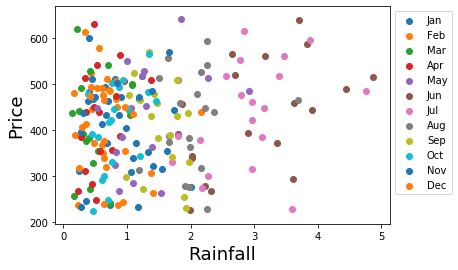

In [15]:
import calendar

rain_price_plot = plt.figure()
for i in range(12):
    plt.scatter(all_vars_by_month[0][i]['value_rain'], all_vars_by_month[0][i]['value_price'], label = calendar.month_abbr[i+1])

plt.xlabel('Rainfall', fontsize = 18)
plt.ylabel('Price', fontsize = 18)
plt.legend(bbox_to_anchor=(1, 1))

In [16]:
prices['Region'].unique()

array(['Alberta', 'British Columbia', 'Manitoba', 'Ontario', 'Québec',
       'Saskatchewan'], dtype=object)

In [17]:
temp_by_region[0][['value']].loc['2010-6-1':'2020-6-10']

,value
end,
2010-06-30 00:00:00+00:00,20.899642
2010-07-31 00:00:00+00:00,21.507508
2010-08-31 00:00:00+00:00,19.512288
2010-09-30 00:00:00+00:00,12.642844
2010-10-31 00:00:00+00:00,10.416640
...,...
2019-10-31 00:00:00+00:00,4.012520
2019-11-30 00:00:00+00:00,-6.195776
2019-12-31 00:00:00+00:00,-11.518811


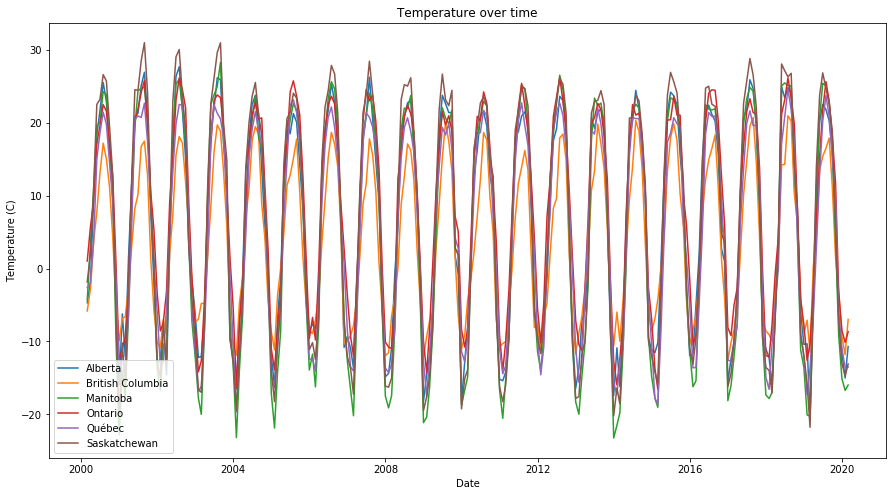

In [31]:
fig1 = plt.figure(figsize=(15,8))
ax1 = fig1.add_subplot()

for i in range(6):
    temp = temp_by_region[i][['value']]#.loc['2010-1-1':'2020-6-10']
    ax1.plot(temp)
    
ax1.set_title("Temperature over time")
ax1.set_xlabel("Date")
ax1.set_ylabel("Temperature (C)")
ax1.legend(['Alberta', 'British Columbia', 'Manitoba', 'Ontario', 'Québec',
       'Saskatchewan'])
plt.savefig('temperature2.png')

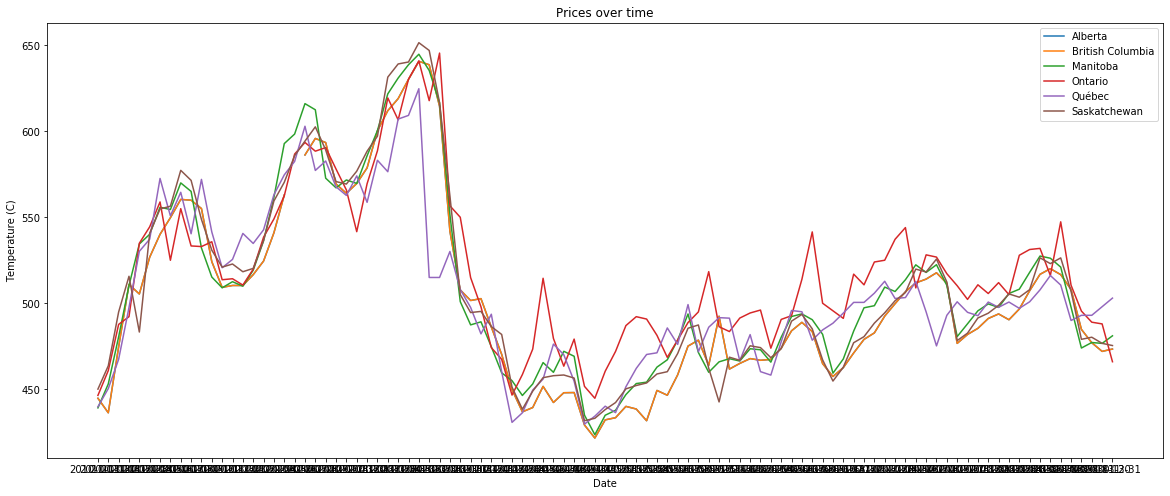

In [19]:
fig1 = plt.figure(figsize=(20,8))
ax1 = fig1.add_subplot()

for i in range(6):
    temp = prices_by_region[i][['value']].loc['2010-1-1':'2020-6-10']
    ax1.plot(temp)
    
ax1.set_title("Prices over time")
ax1.set_xlabel("Date")
ax1.set_ylabel("Temperature (C)")
ax1.legend(['Alberta', 'British Columbia', 'Manitoba', 'Ontario', 'Québec',
       'Saskatchewan'])

In [20]:
temp_by_region[0]

,value,region_id,year
end,,,
2000-02-29 00:00:00+00:00,-4.705915,111101.000000,2000.0
2000-03-31 00:00:00+00:00,-1.752348,111101.023850,2000.0
2000-04-30 00:00:00+00:00,9.410575,111101.000000,2000.0
2000-05-31 00:00:00+00:00,18.326173,111100.998299,2000.0
2000-06-30 00:00:00+00:00,21.634903,111100.989091,2000.0
...,...,...,...
2019-10-31 00:00:00+00:00,4.012520,111101.000000,2019.0
2019-11-30 00:00:00+00:00,-6.195776,111101.000000,2019.0
2019-12-31 00:00:00+00:00,-11.518811,111101.000000,2019.0


In [21]:
#create nested list of LinearRegression objects that predict deliveries value
min_year = 2001
regs = []
score = 0
for i in range(len(regions)):
    regs.append([])
    for month in range(12):
        valid_data = all_vars_by_month[i][month].loc[lambda x: x.index.year >= min_year].loc[lambda x: x.value != 0]
        x = valid_data[['value_temp', 'value_rain']].values
        y = valid_data['value']
        regs[i].append(LinearRegression().fit(x, y))
        
        score += regs[i][month].score(x,y)
score / (len(regions) * 12)

0.17029951284538933

In [22]:
#create nested list of LinearRegression objects that predict prices value
regs_price = []
score = 0
for i in range(len(regions)):
    regs_price.append([])
    for month in range(12):
        valid_data = all_vars_by_month[i][month].loc[lambda x: x.index.year >= min_year].loc[lambda x: x.value_price.notna()].loc[lambda x: x.value_price != 0]
        x = valid_data[['value_temp', 'value_rain']].values
        y = valid_data['value_price']
        regs_price[i].append(LinearRegression().fit(x, y))
        score += regs_price[i][month].score(x,y)
score / (len(regions) * 12)

0.13378539402631284

[16.48163832069794, 2.3683541448946794]
-1985.0233979432705


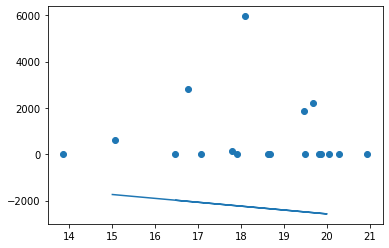

In [23]:
i=6
plt.scatter(all_vars_by_month[1][i].loc[lambda x: x.index.year >= min_year]['value_temp'], all_vars_by_month[1][i].loc[lambda x: x.index.year >= min_year]['value'])

test_temp = temp_by_region[1].loc[lambda x: x.index.year >= 2019]['value'][i]
test_rain = rain_by_region[1].loc[lambda x: x.index.year >= 2019]['value'][i]
x_test = [[15, test_rain], [20, test_rain], [test_temp,test_rain]]
y_test = regs[1][i].predict(x_test)
plt.plot([15,20,test_temp], y_test)
print(x_test[2])
print(y_test[2])

[16.48163832069794, 2.3683541448946794]
-1985.0233979432705


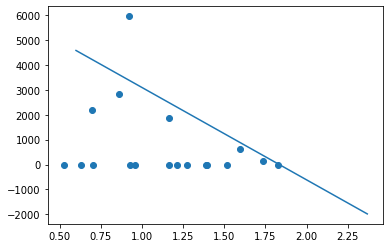

In [24]:
plt.scatter(all_vars_by_month[1][i].loc[lambda x: x.index.year >= min_year]['value_rain'], all_vars_by_month[1][i].loc[lambda x: x.index.year >= min_year]['value'])

x_test = [[test_temp, 0.6], [test_temp, 1.8], [test_temp,test_rain]]
y_test = regs[1][i].predict(x_test)
plt.plot([0.6,1.8,test_rain], y_test)
print(x_test[2])
print(y_test[2])

In [25]:
#uses nested list of LinearRegression objects to create nested list of predictions for 2019 deliveries
preds = []
pred_year = 2019
for i in range(len(regions)):
    preds.append([])
    for month in range(12):
        temp_min = all_vars_by_month[i][month]['value_temp'].min()
        temp_max = all_vars_by_month[i][month]['value_temp'].max()
        rain_min = all_vars_by_month[i][month]['value_rain'].min()
        rain_max = all_vars_by_month[i][month]['value_rain'].max()
        
        temps = temp_by_region[i].loc[lambda x: x.index.year >= pred_year]['value'][month]
        rains = rain_by_region[i].loc[lambda x: x.index.year >= pred_year]['value'][month]
        
        temps = min(max(temps, temp_min), temp_max)
        rains = min(max(rains, rain_min), rain_max)
        
        elninos = elNino_f[lambda x: x.index.year >= pred_year]['value'][month]
        new_x = np.array([temps, rains]).reshape(-1, 2)
        preds[i].append(regs[i][month].predict(new_x)[0])

In [26]:
#uses nested list of LinearRegression objects to create nested list of predictions for 2019 prices
preds_price = []
pred_year = 2019
for i in range(len(regions)):
    preds_price.append([])
    for month in range(12):
        temp_min = all_vars_by_month[i][month]['value_temp'].min()
        temp_max = all_vars_by_month[i][month]['value_temp'].max()
        rain_min = all_vars_by_month[i][month]['value_rain'].min()
        rain_max = all_vars_by_month[i][month]['value_rain'].max()
        
        temps = temp_by_region[i].loc[lambda x: x.index.year >= pred_year]['value'][month]
        rains = rain_by_region[i].loc[lambda x: x.index.year >= pred_year]['value'][month]
        
        temps = min(max(temps, temp_min), temp_max)
        rains = min(max(rains, rain_min), rain_max)
        
        elninos = elNino_f[lambda x: x.index.year >= pred_year]['value'][month]
        new_x = np.array([temps, rains]).reshape(-1, 2)
        preds_price[i].append(regs_price[i][month].predict(new_x)[0])

In [27]:
#flattens delivery predictions to 1 dimension, to be written to dataframe
preds_1d = []
for i in range(len(regions)):
    for month in range(12):
        preds_1d.append(preds[i][month])

In [28]:
#flattens price predictions to 1 dimension, to be written to dataframe
preds_price_1d = []
for i in range(len(regions)):
    for month in range(12):
        preds_price_1d.append(preds_price[i][month])

In [29]:
#writes predictions to dataframe
output = result
output['Deliveries'] = preds_1d
output['Prices'] = preds_price_1d

In [30]:
#exports output dataframe to csv
output.to_csv('solution.csv', index=False)